# NLP exploration of the "7tomorrow" database (executed on Google Colab)

Here we investigate how the NLP strategies tested in the previous notebook "[Genevieve]NLP_explore.ipynb" for the french JOW database generalize to the english database of "projet7tomorrow". 


In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from time import time

Show the gpu infos and change if needed in "Execution" panel.   
Using GPUs is not compulsory here. I moved to Google Colab because my computer is slow.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb  6 12:10:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import from Google Drive.  
Here the folder 'carbondiet4GD' only contains the folder data/ with subfolders Recipes/ and Tools/ (others are not used).

In [53]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/carbondiet4GD.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')     # create a copy directly in colab for efficiency reasons

Mounted at /content/drive


**Indicate the path where the folder data/ is located.**

In [7]:
#data_path = '../'
data_path = 'carbondiet4GD/'

##Import the 7t recipe database translated in french

In [83]:
seven_path = data_path + 'data/Recipes/recettes_completes_7tomorrow_preprocessed.xlsx'
seven_data = pd.read_excel(seven_path, header = [0])
seven_data.head()

,Unnamed: 0,title_raw,ingredient_basics,ingredient_basics_fr,title_raw_fr
0,0,""" child's play"" sour pops","lime juice, lemon juice","jus de citron vert, jus de citron","""Play de l'enfant"" Sour Pops"
1,1,""" fried egg sundaes""","ice cream, cream, spice","glace, crème, épices","""Sundaes aux œufs au plat"""
2,2,""" world's best ""( and easiest ) teriyaki chick...","chicken, soy sauce soy, sugar","poulet, sauce de soja, du sucre","""Best du monde"" (et les plus faciles) Ailes de..."
3,3,"""apple crisp"" peanut butter snack bites","peanut butter, honey, oat, nut, apple, spice","beurre d'arachide, miel, avoine, noix, Pomme, ...","Bites de collations au beurre d'arachide ""pomm..."
4,4,"""berry good"" smoothie","apple juice, strawberry, raspberry, blackberry...","jus de pomme, fraise, framboise, la mûre, myrt...","Smoothie ""Berry Good"""


In [75]:
seven_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7418 entries, 0 to 7417
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            7418 non-null   int64 
 1   title_raw             7418 non-null   object
 2   ingredient_basics     7418 non-null   object
 3   ingredient_basics_fr  7418 non-null   object
 4   title_raw_fr          7418 non-null   object
dtypes: int64(1), object(4)
memory usage: 289.9+ KB


Remove doublons in ingredient lists

In [86]:
seven_data['ingredient_basics'] = seven_data['ingredient_basics'].apply(lambda l: ', '.join(list(set(l.split(', ')))))
seven_data['ingredient_basics_fr'] = seven_data['ingredient_basics_fr'].apply(lambda l: ', '.join(list(set(l.split(', ')))))

In [90]:
seven_data.head(10)

,Unnamed: 0,title_raw,ingredient_basics,ingredient_basics_fr,title_raw_fr,name_with_ingredients,name_with_ingredients_fr
0,0,""" child's play"" sour pops","lime juice, lemon juice","jus de citron vert, jus de citron","""Play de l'enfant"" Sour Pops",""" child's play"" sour pops, lime juice, lemon j...","""Play de l'enfant"" Sour Pops, jus de citron ve..."
1,1,""" fried egg sundaes""","ice cream, cream, spice","crème, glace, épices","""Sundaes aux œufs au plat""",""" fried egg sundaes"", ice cream, cream, spice","""Sundaes aux œufs au plat"", crème, glace, épices"
2,2,""" world's best ""( and easiest ) teriyaki chick...","chicken, sugar, soy sauce soy","du sucre, sauce de soja, poulet","""Best du monde"" (et les plus faciles) Ailes de...",""" world's best ""( and easiest ) teriyaki chick...","""Best du monde"" (et les plus faciles) Ailes de..."
3,3,"""apple crisp"" peanut butter snack bites","peanut butter, oat, apple, nut, honey, spice","épices, miel, avoine, noix, beurre d'arachide,...","Bites de collations au beurre d'arachide ""pomm...","""apple crisp"" peanut butter snack bites, peanu...","Bites de collations au beurre d'arachide ""pomm..."
4,4,"""berry good"" smoothie","raspberry, blackberry, blueberry, strawberry, ...","framboise, myrtille, la mûre, fraise, jus de p...","Smoothie ""Berry Good""","""berry good"" smoothie, raspberry, blackberry, ...","Smoothie ""Berry Good"", framboise, myrtille, la..."
5,5,"""chinese"" popcorn","lemon juice, noodle, soy sauce soy, corn, oil...","nouille, épices, huile, maïs, beurre, jus de c...","pop-corn ""chinois""","""chinese"" popcorn, lemon juice, noodle, soy sa...","pop-corn ""chinois"", nouille, épices, huile, ma..."
6,6,"""creamed"" cabbage and cauliflower","milk, cabbage, butter, potato, cauliflower, spice","épices, lait, Patate, beurre, choufleur, chou","chou et chou-fleur ""à la crème""","""creamed"" cabbage and cauliflower, milk, cabba...","chou et chou-fleur ""à la crème"", épices, lait,..."
7,7,"""dare to be different "" dip","orange juice, peanut butter, cheese, carrot","du jus d'orange, beurre d'arachide, carotte, f...","""oser être différent"" Dip","""dare to be different "" dip, orange juice, pea...","""oser être différent"" Dip, du jus d'orange, be..."
8,8,"""fried"" potatoes","potato, margarine, spice","Patate, margarine, épices","""patates frites","""fried"" potatoes, potato, margarine, spice","""patates frites, Patate, margarine, épices"
9,9,"""i can't believe it is butter"" margarine spread","milk, margarine, oil, butter","lait, beurre, huile, margarine","""Je ne peux pas croire que ce soit du beurre"" ...","""i can't believe it is butter"" margarine sprea...","""Je ne peux pas croire que ce soit du beurre"" ..."


Concatenate recipe names and ingredients

In [91]:
seven_data['name_with_ingredients'] = seven_data.apply(lambda row: row['title_raw'] + ", " + row['ingredient_basics'], axis = 1)
seven_data['name_with_ingredients_fr'] = seven_data.apply(lambda row: row['title_raw_fr'] + ", " + row['ingredient_basics_fr'], axis = 1)

In [92]:
seven_data.head()

,Unnamed: 0,title_raw,ingredient_basics,ingredient_basics_fr,title_raw_fr,name_with_ingredients,name_with_ingredients_fr
0,0,""" child's play"" sour pops","lime juice, lemon juice","jus de citron vert, jus de citron","""Play de l'enfant"" Sour Pops",""" child's play"" sour pops, lime juice, lemon j...","""Play de l'enfant"" Sour Pops, jus de citron ve..."
1,1,""" fried egg sundaes""","ice cream, cream, spice","crème, glace, épices","""Sundaes aux œufs au plat""",""" fried egg sundaes"", ice cream, cream, spice","""Sundaes aux œufs au plat"", crème, glace, épices"
2,2,""" world's best ""( and easiest ) teriyaki chick...","chicken, sugar, soy sauce soy","du sucre, sauce de soja, poulet","""Best du monde"" (et les plus faciles) Ailes de...",""" world's best ""( and easiest ) teriyaki chick...","""Best du monde"" (et les plus faciles) Ailes de..."
3,3,"""apple crisp"" peanut butter snack bites","peanut butter, oat, apple, nut, honey, spice","épices, miel, avoine, noix, beurre d'arachide,...","Bites de collations au beurre d'arachide ""pomm...","""apple crisp"" peanut butter snack bites, peanu...","Bites de collations au beurre d'arachide ""pomm..."
4,4,"""berry good"" smoothie","raspberry, blackberry, blueberry, strawberry, ...","framboise, myrtille, la mûre, fraise, jus de p...","Smoothie ""Berry Good""","""berry good"" smoothie, raspberry, blackberry, ...","Smoothie ""Berry Good"", framboise, myrtille, la..."


##Import the NLP model (for french language)

In [14]:
! pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 813.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 111.9 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=5374206b9d4e41c24195d576b67af142457ef74e7542128b221d75d9da8980c0
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence_transformers


In [15]:
from sentence_transformers import SentenceTransformer
model =  SentenceTransformer("dangvantuan/sentence-camembert-large")

## Calcule the recipes' embeddings




In [94]:
t0 = time()
seven_fullname_recipes_fr = list(seven_data['name_with_ingredients_fr'].values)
seven_fullname_embeddings_fr = model.encode(seven_fullname_recipes_fr, convert_to_tensor=True)
print("Time lapse for 7tomorrow recipes' embedding (s) = ", time()-t0)

Time lapse for 7tomorrow recipes' embedding (s) =  35.159026861190796


## Import and prepare the menu database
Import the file that has been prepared with a list of menu recipes and their corresponding 7t recipes.   
Note that the matching has been done by hand in a former step (and may contain errors).

In [61]:
menu_data = pd.read_excel(data_path+'data/Tools/MenuTo7tRecipes_v1.xlsx', header = [0])
menu_data.head(10)

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand
0,3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette...",Not yet handled,"['awesome turkey burgers', 'blue cheese stuffe..."
1,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,NaN,Mousse au chocolat maison,"['chocolate mousse', 'chocolate dream mousse',..."
2,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,NaN,Fondant au chocolat,no match
3,17,Carte-in-seoul.png,Anju,Mandoo (6 pcs),Raviolis maison grillés au porc et légumes,no match,no match
4,18,Carte-in-seoul.png,Anju,Haemul Jeol,Galette de fruit mer,no match,no match
5,19,Carte-in-seoul.png,Anju,Sewoo kkanpoong (8 pcs),Crevettes frites dans une sauce aigre douce,"['Crevettes teriyaki', 'Crevettes miel sésame']",no match
6,20,Carte-in-seoul.png,Bibimbap,Dolsot bibimbap (en pierrade au choix),Bœuf,no match,no match
7,21,Carte-in-seoul.png,Chicken,"YangNyeom chicken (5pcs, 12pcs, 24pcs)",Poulet frit enrobé de sauce + salade,no match,korean bbq chicken
8,22,Carte-in-seoul.png,Classiques,Bulgogi,"Bœuf émincé à la sauce soja, légumes, riz","['Wok de bœuf légumes croquants', 'Bœuf thaï',...",beef bulgogi(korean marinated beef)
9,23,Carte-in-seoul.png,Classiques,Jeyuk,"Porc sauté, légumes, riz - soja ou piquant",Porc au caramel,no match


Prepare the list of queries for test, first by concatenating the title and subtitle of menu recipes 

In [62]:
menu_data['Menu Title and Subtitle'] = menu_data.apply(lambda row: row['Menu Title'] + ", " + row['Menu Subtitle'], axis = 1)
menu_data.head()

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle
0,3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette...",Not yet handled,"['awesome turkey burgers', 'blue cheese stuffe...","Burgers, Green Chicken"
1,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,NaN,Mousse au chocolat maison,"['chocolate mousse', 'chocolate dream mousse',...","Desserts, Mousse au chocolat maison"
2,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,NaN,Fondant au chocolat,no match,"Desserts, Fondant au chocolat artisan boulanger"
3,17,Carte-in-seoul.png,Anju,Mandoo (6 pcs),Raviolis maison grillés au porc et légumes,no match,no match,"Anju, Mandoo (6 pcs)"
4,18,Carte-in-seoul.png,Anju,Haemul Jeol,Galette de fruit mer,no match,no match,"Anju, Haemul Jeol"


Replace NaN in the ingredients column by empty string

In [63]:
menu_data = menu_data.fillna("")
menu_data.head()

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle
0,3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette...",Not yet handled,"['awesome turkey burgers', 'blue cheese stuffe...","Burgers, Green Chicken"
1,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"['chocolate mousse', 'chocolate dream mousse',...","Desserts, Mousse au chocolat maison"
2,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,no match,"Desserts, Fondant au chocolat artisan boulanger"
3,17,Carte-in-seoul.png,Anju,Mandoo (6 pcs),Raviolis maison grillés au porc et légumes,no match,no match,"Anju, Mandoo (6 pcs)"
4,18,Carte-in-seoul.png,Anju,Haemul Jeol,Galette de fruit mer,no match,no match,"Anju, Haemul Jeol"


Do the same by concatenating the title, subtitle and ingredients of menu recipes

In [64]:
def add_ingredients(row):
    if row['Menu Ingredients']=='':
        res = row['Menu Title'] + ", " + row['Menu Subtitle']
    else:
        res = row['Menu Title'] + ", " + row['Menu Subtitle'] + ", " + row['Menu Ingredients']
    return res

menu_data['Menu all'] = menu_data.apply(add_ingredients, axis = 1)
menu_data.head(8)

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle,Menu all
0,3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette...",Not yet handled,"['awesome turkey burgers', 'blue cheese stuffe...","Burgers, Green Chicken","Burgers, Green Chicken, Filet de poulet, Tomme..."
1,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"['chocolate mousse', 'chocolate dream mousse',...","Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison"
2,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,no match,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger"
3,17,Carte-in-seoul.png,Anju,Mandoo (6 pcs),Raviolis maison grillés au porc et légumes,no match,no match,"Anju, Mandoo (6 pcs)","Anju, Mandoo (6 pcs), Raviolis maison grillés ..."
4,18,Carte-in-seoul.png,Anju,Haemul Jeol,Galette de fruit mer,no match,no match,"Anju, Haemul Jeol","Anju, Haemul Jeol, Galette de fruit mer"
5,19,Carte-in-seoul.png,Anju,Sewoo kkanpoong (8 pcs),Crevettes frites dans une sauce aigre douce,"['Crevettes teriyaki', 'Crevettes miel sésame']",no match,"Anju, Sewoo kkanpoong (8 pcs)","Anju, Sewoo kkanpoong (8 pcs), Crevettes frite..."
6,20,Carte-in-seoul.png,Bibimbap,Dolsot bibimbap (en pierrade au choix),Bœuf,no match,no match,"Bibimbap, Dolsot bibimbap (en pierrade au choix)","Bibimbap, Dolsot bibimbap (en pierrade au choi..."
7,21,Carte-in-seoul.png,Chicken,"YangNyeom chicken (5pcs, 12pcs, 24pcs)",Poulet frit enrobé de sauce + salade,no match,korean bbq chicken,"Chicken, YangNyeom chicken (5pcs, 12pcs, 24pcs)","Chicken, YangNyeom chicken (5pcs, 12pcs, 24pcs..."


**We keep only menu recipes that have been successfully matched -by hand- with 7t recipes.**

In [65]:
menu_data_withmatch = menu_data[menu_data['Closest 7t recipe by hand']!='no match']
print("Number of queries = ", menu_data_withmatch.shape[0])

Number of queries =  12


In [128]:
menu_data_withmatch

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle,Menu all
0,3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette...",Not yet handled,"['awesome turkey burgers', 'blue cheese stuffe...","Burgers, Green Chicken","Burgers, Green Chicken, Filet de poulet, Tomme..."
1,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"['chocolate mousse', 'chocolate dream mousse',...","Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison"
7,21,Carte-in-seoul.png,Chicken,"YangNyeom chicken (5pcs, 12pcs, 24pcs)",Poulet frit enrobé de sauce + salade,no match,korean bbq chicken,"Chicken, YangNyeom chicken (5pcs, 12pcs, 24pcs)","Chicken, YangNyeom chicken (5pcs, 12pcs, 24pcs..."
8,22,Carte-in-seoul.png,Classiques,Bulgogi,"Bœuf émincé à la sauce soja, légumes, riz","['Wok de bœuf légumes croquants', 'Bœuf thaï',...",beef bulgogi(korean marinated beef),"Classiques, Bulgogi","Classiques, Bulgogi, Bœuf émincé à la sauce so..."
12,27,Carte-Restaurant-Nelsons-Paris-Jour-2-1024x724...,Salades,La César,"poulet grillé, tomates cerise, œuf, romaine, p...",Salade César,['better-for-you grilled chicken caesar salad'...,"Salades, La César","Salades, La César, poulet grillé, tomates ceri..."
13,28,Carte-Restaurant-Nelsons-Paris-Jour-2-1024x724...,Salades,La Biquette de Rocamadour,mielleuse et craquante,"['Salade de chèvre chaud', 'Salade chèvre, mie...",['waldorf goat cheese salad'],"Salades, La Biquette de Rocamadour","Salades, La Biquette de Rocamadour, mielleuse ..."
17,43,feaa6c7b-9b16-4d51-b71d-75518f16cb08.jpg,Hox Signatures,Beyond meat veggie burger,"Beyond Meat pattie, charcoal bun, avocado, fri...",Cheeseburger veggie,"['amara veggie burgers', 'the woodward veggie ...","Hox Signatures, Beyond meat veggie burger","Hox Signatures, Beyond meat veggie burger, Bey..."
18,44,feaa6c7b-9b16-4d51-b71d-75518f16cb08.jpg,Sides,Frites,(v),no match,perfectly simple french fries,"Sides, Frites","Sides, Frites, (v)"
19,45,feaa6c7b-9b16-4d51-b71d-75518f16cb08.jpg,Sides,Frites patate douce,"Parmesan cheese, rosemary, spicy mayo",no match,"['sweet potato fries', 'sweet-hot bbq tater fr...","Sides, Frites patate douce","Sides, Frites patate douce, Parmesan cheese, r..."
27,59,menu_bobby.jpg,Pasta Fresca,Limone,"Trenette, sauce au citron, piment (ou non si v...",Pasta al limone,"['lemon basil spaghetti', 'lemon butter parmes...","Pasta Fresca, Limone","Pasta Fresca, Limone, Trenette, sauce au citro..."


## Run the NLP model (7t + menu recipes in french)

In [120]:
from sentence_transformers import util
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

dict_res = {}

# Find the closest 10 recipes of the (7t) corpus for each query recipe based on cosine similarity
for index, row in menu_data_withmatch.iterrows():
    query = row['Menu all']           # Menu recipes are labeled by their titles, subtitles, and ingredients
    print("\n======================\n")
    query_embedding = model.encode(query, convert_to_tensor=True)
    
    # We use util.semantic_search to perform cosine similarty + topk
    printmd("**Query : "+query+"**")
    printmd("**Closest 7t recipe (by hand) : "+row['Closest 7t recipe by hand']+"**")
    print("\nTop 10 most similar recipes in 7t:")
    hits = util.semantic_search(query_embedding, seven_fullname_embeddings_fr, top_k=10)
    hits = hits[0]      #Get the hits for the first query
    

    for k, hit in enumerate(hits):
        seven_recipe = seven_fullname_recipes_fr[hit['corpus_id']]
        print(k+1, ") ", seven_recipe, "(Score: {:.4f})".format(hit['score']))
        print('--> English name = ', list(seven_data[seven_data['name_with_ingredients_fr']==seven_recipe]['title_raw']))
        print('--> ingredients = ', list(seven_data[seven_data['name_with_ingredients_fr']==seven_recipe]['ingredient_basics']))

    # Store results in a dictionary
    for k, hit in enumerate(hits):
        seven_recipe_fr = seven_fullname_recipes_fr[hit['corpus_id']]
        seven_recipe_en = seven_data[seven_data['name_with_ingredients_fr']==seven_recipe_fr]['title_raw'].values[0]
       
        closest_seven = row['Closest 7t recipe by hand']
        
        if closest_seven[0]=='[':       # To detect lists because they have been converted to strings. Bad, Bad!
            matched_idx = 1 if seven_recipe_en in closest_seven else 0
        else:
            matched_idx = 1 if seven_recipe_en==closest_seven else 0

        # For each menu recipe (index) and hit (k), store menu_recipe_id, menu_recipe_label, jow_guess, similarity_rank, similary_score, is_matched
        dict_res[str(index)+'_'+str(k)] = [query, query, seven_recipe_en, k+1, hit['score'], matched_idx]   


**Query : Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison**

**Closest 7t recipe (by hand) : ['awesome turkey burgers', 'blue cheese stuffed turkey burgers', 'chicken & broccoli burgers', 'greek burgers', 'spinach feta turkey burgers']**


Top 10 most similar recipes in 7t:
1 )  poulet et brocoli hamburgers, brocoli, fromage, poulet (Score: 0.6697)
--> English name =  ['chicken & broccoli burgers']
--> ingredients =  ['chicken, cheese, broccoli']
2 )  Burgers de dinde feta épinards, vinaigrette, graines, fromage, épices, épinard, dinde hachée (Score: 0.6579)
--> English name =  ['spinach feta turkey burgers']
--> ingredients =  ['salad dressing, ground turkey, seed, cheese, spinach, spice']
3 )  Recette de pizza au poulet de style buffle, fromage, épices, sauce, beurre, poulet, céleri (Score: 0.6380)
--> English name =  ['buffalo style chicken pizza recipe']
--> ingredients =  ['chicken, sauce, cheese, butter, celery, spice']
4 )  hamburgers de dinde farci au fromage bleu, huile, dinde hachée, fromage, épices (Score: 0.6369)
--> English name =  ['blue cheese stuffed turkey burgers']
--> ingredients =  ['ground turkey, cheese, oil, spice']
5 )  Franks Chicken Wing Dip, vinaigrette, fromage, poulet (Score: 0.6357)
--> Eng

**Query : Desserts, Mousse au chocolat maison**

**Closest 7t recipe (by hand) : ['chocolate mousse', 'chocolate dream mousse', 'raw chocolate mousse, lactose free']**


Top 10 most similar recipes in 7t:
1 )  Mousse de pâte à gâteau au chocolat, crème (Score: 0.8682)
--> English name =  ['chocolate cake batter mousse']
--> ingredients =  ['cream']
2 )  recette de fondue de dessert au chocolat, lait, Chocolat, crème (Score: 0.7388)
--> English name =  ['chocolate dessert fondue recipe']
--> ingredients =  ['chocolate, milk, cream']
3 )  mousse de gâteau au fromage au chocolat, cacao, miel, fromage (Score: 0.7378)
--> English name =  ['chocolate cheesecake mousse']
--> ingredients =  ['cheese, cocoa, honey']
4 )  Fondue de dessert au chocolat, lait, noix, beurre, Des bonbons, crème (Score: 0.7200)
--> English name =  ['chocolate dessert fondue']
--> ingredients =  ['milk, candy, cream, butter, nut']
5 )  recette de ganache au chocolat facile, beurre, Des bonbons, crème (Score: 0.7044)
--> English name =  ['easy chocolate ganache recipe']
--> ingredients =  ['candy, cream, butter']
6 )  Soupe au chocolat avec croûtons brownies et dessert de mousse, lait

**Query : Chicken, YangNyeom chicken (5pcs, 12pcs, 24pcs), Poulet frit enrobé de sauce + salade**

**Closest 7t recipe (by hand) : korean bbq chicken**


Top 10 most similar recipes in 7t:
1 )  Sandwiche de salade au Poulet, vinaigrette, poulet, épices (Score: 0.6661)
--> English name =  ['chicken salad sandwiches']
--> ingredients =  ['chicken, salad dressing, spice']
2 )  Buffalo Chicken Wings 2, beurre, poulet, épices (Score: 0.6661)
--> English name =  ['buffalo chicken wings 2']
--> ingredients =  ['butter, chicken, spice']
3 )  Franks Chicken Wing Dip, vinaigrette, fromage, poulet (Score: 0.6625)
--> English name =  ['franks chicken wing dip']
--> ingredients =  ['chicken, cheese, salad dressing']
4 )  Copycat Wings and Things Chicken Tenders and Hot Sauce, beurre, le vinaigre, poulet, épices (Score: 0.6472)
--> English name =  ['copycat wings and things chicken tenders and hot sauce']
--> ingredients =  ['butter, chicken, spice, vinegar']
5 )  K-Jons Buffalo Chicken Tand, fromage, épices, oignon, beurre, poulet (Score: 0.6454)
--> English name =  ['k-jons buffalo chicken dip']
--> ingredients =  ['chicken, cheese, butter, onion,

**Query : Classiques, Bulgogi, Bœuf émincé à la sauce soja, légumes, riz**

**Closest 7t recipe (by hand) : beef bulgogi(korean marinated beef)**


Top 10 most similar recipes in 7t:
1 )  Boîte Bulgogi (bœuf mariné coréen), graines, du boeuf, épices, oignon, huile, du sucre, sauce de soja (Score: 0.7018)
--> English name =  ['beef bulgogi(korean marinated beef)']
--> ingredients =  ['soy sauce  soy, oil, sugar, seed, beef, onion, spice']
2 )  Recette de bœuf ou de chevreuil saccadée, sauce de soja, épices (Score: 0.6916)
--> English name =  ['beef or venison jerky recipe']
--> ingredients =  ['soy sauce  soy, spice']
3 )  Boeuf de barbecue copieux, porc, sauce de soja, sauce, épices (Score: 0.6697)
--> English name =  ['hearty bbq beef short ribs']
--> ingredients =  ['pork, spice, sauce, soy sauce  soy']
4 )  riz frit facile avec légumes, sauce de soja, huile, légume, riz (Score: 0.6673)
--> English name =  ['easy fried rice with veggies']
--> ingredients =  ['vegetable, oil, rice, soy sauce  soy']
5 )  Recette de style tofu cuit au tofu, épices, Tofu, huile, riz, beurre d'arachide, sauce de soja (Score: 0.6446)
--> English name

**Query : Salades, La César, poulet grillé, tomates cerise, œuf, romaine, parmesan**

**Closest 7t recipe (by hand) : ['better-for-you grilled chicken caesar salad', 'favorite grilled chicken caesar salad', 'grilled chicken a la caesar', 'grilled chicken caesar salad']**


Top 10 most similar recipes in 7t:
1 )  Salade de césar de poulet grillé mieux pour vous, vinaigrette, fromage, croûton, poulet, laitue (Score: 0.7295)
--> English name =  ['better-for-you grilled chicken caesar salad']
--> ingredients =  ['chicken, salad dressing, lettuce, crouton, cheese']
2 )  salade de césar de poulet grillé, vinaigrette, fromage, croûton, poulet, laitue (Score: 0.7220)
--> English name =  ['grilled chicken caesar salad']
--> ingredients =  ['chicken, salad dressing, lettuce, crouton, cheese']
3 )  poulet grillé à la césar, vinaigrette, fromage, croûton, poulet, laitue (Score: 0.7111)
--> English name =  ['grilled chicken a la caesar']
--> ingredients =  ['chicken, salad dressing, lettuce, crouton, cheese']
4 )  salade de césar de poulet grillé préféré, vinaigrette, fromage, croûton, poulet, laitue (Score: 0.6958)
--> English name =  ['favorite grilled chicken caesar salad']
--> ingredients =  ['chicken, salad dressing, lettuce, crouton, cheese']
5 )  poulet tosca

**Query : Salades, La Biquette de Rocamadour, mielleuse et craquante**

**Closest 7t recipe (by hand) : ['waldorf goat cheese salad']**


Top 10 most similar recipes in 7t:
1 )  salade de papple croccoli croquante, vinaigrette, fromage, noix, canneberge, brocoli, oignon rouge frais, Pomme (Score: 0.4759)
--> English name =  ['crunchy broccoli-apple salad']
--> ingredients =  ['salad dressing, cranberry, apple, broccoli, cheese, fresh red onion, nut']
2 )  vinaigrette à la salade de baies au fromage crémeux de maman, fromage, noix (Score: 0.4441)
--> English name =  ["mom's creamy cheesy berry salad dressing"]
--> ingredients =  ['cheese, nut']
3 )  salade de poulet à la cannette, vinaigrette, riz sauvage, noix, canneberge, céleri, Pomme, dinde hachée (Score: 0.4417)
--> English name =  ['cranberry-crunch chicken salad']
--> ingredients =  ['salad dressing, ground turkey, cranberry, wild rice, apple, celery, nut']
4 )  salade de bouledogue, vinaigrette, raisin, noix, Des bonbons, crème, yaourt, céleri, Pomme (Score: 0.4413)
--> English name =  ['bulldog salad']
--> ingredients =  ['candy, salad dressing, apple, cream, ra

**Query : Hox Signatures, Beyond meat veggie burger, Beyond Meat pattie, charcoal bun, avocado, fries, salad**

**Closest 7t recipe (by hand) : ['amara veggie burgers', 'the woodward veggie burger']**


Top 10 most similar recipes in 7t:
1 )  recette de garniture de hamburger barbecue, vinaigrette, oignon, sauce (Score: 0.6222)
--> English name =  ['barbecue burger topping recipe']
--> ingredients =  ['onion, sauce, salad dressing']
2 )  le burger végétarien de Woodward, graines, épices, oignon, huile, riz, noix, sauce de soja (Score: 0.6122)
--> English name =  ['the woodward veggie burger']
--> ingredients =  ['soy sauce  soy, oil, nut, seed, onion, rice, spice']
3 )  poulet et brocoli hamburgers, brocoli, fromage, poulet (Score: 0.6053)
--> English name =  ['chicken & broccoli burgers']
--> ingredients =  ['chicken, cheese, broccoli']
4 )  hamburgers végétariens amara, graines, farine de blé, carotte, poivre, riz, beurre d'arachide (Score: 0.5996)
--> English name =  ['amara veggie burgers']
--> ingredients =  ['peanut butter, wheat flour, seed, pepper, carrot, rice']
5 )  hamburgers de dinde farci au fromage bleu, huile, dinde hachée, fromage, épices (Score: 0.5992)
--> English n

**Query : Sides, Frites, (v)**

**Closest 7t recipe (by hand) : perfectly simple french fries**


Top 10 most similar recipes in 7t:
1 )  frites parfaitement simples, huile, Patate (Score: 0.6032)
--> English name =  ['perfectly simple french fries']
--> ingredients =  ['potato, oil']
2 )  frites non frit, vinaigrette, Patate, fromage (Score: 0.5697)
--> English name =  ['un-fried french fries']
--> ingredients =  ['potato, cheese, salad dressing']
3 )  Fiesta Dip pour fritos, oignon, fromage, crème (Score: 0.5469)
--> English name =  ['fiesta dip for fritos']
--> ingredients =  ['onion, cheese, cream']
4 )  Croustillant des «frites» des navets, navet, huile, fromage, épices (Score: 0.5459)
--> English name =  ["crispy turnip 'fries'"]
--> ingredients =  ['turnip, cheese, oil, spice']
5 )  Frises de taternes barbecue chauffées, du sucre, patate douce, huile, épices (Score: 0.4974)
--> English name =  ['sweet-hot bbq tater fries']
--> ingredients =  ['sweet potato, oil, sugar, spice']
6 )  frites non coiffées, vinaigrette, Patate, fromage (Score: 0.4958)
--> English name =  ['unfri

**Query : Sides, Frites patate douce, Parmesan cheese, rosemary, spicy mayo**

**Closest 7t recipe (by hand) : ['sweet potato fries', 'sweet-hot bbq tater fries', 'sweet potato fries with bbq mayo']**


Top 10 most similar recipes in 7t:
1 )  pommes de terre frit au four parmesan, Patate, huile, fromage, épices (Score: 0.6978)
--> English name =  ['parmesan oven-fried potatoes']
--> ingredients =  ['potato, cheese, oil, spice']
2 )  Rosemary Parmesan Crisps, fromage, épices (Score: 0.6931)
--> English name =  ['rosemary parmesan crisps']
--> ingredients =  ['cheese, spice']
3 )  quartiers croustillants de pomme de terre parmesan, vinaigrette, Patate, fromage (Score: 0.6853)
--> English name =  ['parmesan potato crisp wedges']
--> ingredients =  ['potato, cheese, salad dressing']
4 )  pommes de terre parmesanes du four, huile, Patate, fromage, épices (Score: 0.6814)
--> English name =  ['oven-fried parmesan potatoes']
--> ingredients =  ['potato, cheese, oil, spice']
5 )  "patates frites, Patate, margarine, épices (Score: 0.6527)
--> English name =  ['"fried" potatoes']
--> ingredients =  ['potato, margarine, spice']
6 )  Les crêpes de salade de pommes de terre incrustées parmesan, hu

**Query : Pasta Fresca, Limone, Trenette, sauce au citron, piment (ou non si vous aimez pas ), basilico**

**Closest 7t recipe (by hand) : ['lemon basil spaghetti', 'lemon butter parmesan linguini']**


Top 10 most similar recipes in 7t:
1 )  Spaghetti au basilic au citron, fromage, nouille, épices, huile, jus de citron (Score: 0.7148)
--> English name =  ['lemon basil spaghetti']
--> ingredients =  ['lemon juice, noodle, oil, cheese, spice']
2 )  recette de sauce au citron facile pour les légumes, vinaigrette, jus de citron, moutarde, crème (Score: 0.6370)
--> English name =  ['easy lemon sauce for veggies recipe']
--> ingredients =  ['mustard, cream, lemon juice, salad dressing']
3 )  au citron beurre parmesan linguini, fromage, nouille, épices, beurre, jus de citron (Score: 0.6356)
--> English name =  ['lemon butter parmesan linguini']
--> ingredients =  ['lemon juice, noodle, cheese, butter, spice']
4 )  vinaigrette à pâtes, vinaigrette, miel, persil, poireau, jus de citron (Score: 0.6286)
--> English name =  ['pasta salad dressing']
--> ingredients =  ['leek, lemon juice, salad dressing, honey, parsley']
5 )  sauce mayonnaise au citron, vinaigrette, jus de citron, aneth (Score: 

**Query : Hamburgers de qualité, Vegan Forest Nirvana, Pain vegan, steak végétal "Les nouveaux Fermiers", cheddar vegan, ketchup, moutarde, pickles**

**Closest 7t recipe (by hand) : tofu burgers**


Top 10 most similar recipes in 7t:
1 )  Hamburgers au tofu, épices, Tofu, huile, sauce, avoine, moutarde, sauce de soja (Score: 0.6299)
--> English name =  ['tofu burgers']
--> ingredients =  ['soy sauce  soy, oat, tofu, oil, sauce, mustard, spice']
2 )  hamburgers de dinde farci au fromage bleu, huile, dinde hachée, fromage, épices (Score: 0.6171)
--> English name =  ['blue cheese stuffed turkey burgers']
--> ingredients =  ['ground turkey, cheese, oil, spice']
3 )  le burger végétarien de Woodward, graines, épices, oignon, huile, riz, noix, sauce de soja (Score: 0.6134)
--> English name =  ['the woodward veggie burger']
--> ingredients =  ['soy sauce  soy, oil, nut, seed, onion, rice, spice']
4 )  super hamburgers de dinde, canneberge, fromage, dinde hachée (Score: 0.6064)
--> English name =  ['awesome turkey burgers']
--> ingredients =  ['ground turkey, cranberry, cheese']
5 )  Burgers de dinde feta épinards, vinaigrette, graines, fromage, épices, épinard, dinde hachée (Score: 0.60

**Query : Pasta, Penne Al Formaggio, Gorgonzola, parmigiano**

**Closest 7t recipe (by hand) : roquefort pasta**


Top 10 most similar recipes in 7t:
1 )  Oodles de nouilles - Pégies et variation parmesan, huile, pois, fromage, Oeuf (Score: 0.5992)
--> English name =  ['oodles of noodles - peas and parmesan variation']
--> ingredients =  ['cheese, oil, pea, egg']
2 )  gnocchis de pesto crémeux, fromage, lait, Patate, sauce, poulet, épinard (Score: 0.5980)
--> English name =  ['creamy pesto gnocchi']
--> ingredients =  ['chicken, milk, sauce, cheese, spinach, potato']
3 )  Spread de pesto mozzarella, sauce, fromage, tomate (Score: 0.5795)
--> English name =  ['mozzarella pesto spread']
--> ingredients =  ['tomato, cheese, sauce']
4 )  Sauce blanche à 100% parmesan, farine de blé, nouille, fromage, lait, beurre (Score: 0.5758)
--> English name =  ['100% parmesan white sauce']
--> ingredients =  ['milk, noodle, wheat flour, cheese, butter']
5 )  Pâtes de pesto crémeux faciles, sauce, nouille, crème (Score: 0.5710)
--> English name =  ['easy creamy pesto pasta']
--> ingredients =  ['sauce, cream, nood

In [121]:
data_res = pd.DataFrame.from_dict(dict_res, orient = 'index', \
                                  columns = ['menu_recipe_id', 'menu_recipe_label', '7t_guess', 'similarity_rank', 'similarity_score', 'is_matched'])\
                                  .reset_index(drop = True)

data_res

,menu_recipe_id,menu_recipe_label,7t_guess,similarity_rank,similarity_score,is_matched
0,"Burgers, Green Chicken, Filet de poulet, Tomme...","Burgers, Green Chicken, Filet de poulet, Tomme...",chicken & broccoli burgers,1,0.669708,1
1,"Burgers, Green Chicken, Filet de poulet, Tomme...","Burgers, Green Chicken, Filet de poulet, Tomme...",spinach feta turkey burgers,2,0.657903,1
2,"Burgers, Green Chicken, Filet de poulet, Tomme...","Burgers, Green Chicken, Filet de poulet, Tomme...",buffalo style chicken pizza recipe,3,0.638046,0
3,"Burgers, Green Chicken, Filet de poulet, Tomme...","Burgers, Green Chicken, Filet de poulet, Tomme...",blue cheese stuffed turkey burgers,4,0.636880,1
4,"Burgers, Green Chicken, Filet de poulet, Tomme...","Burgers, Green Chicken, Filet de poulet, Tomme...",franks chicken wing dip,5,0.635661,0
...,...,...,...,...,...,...
115,"Pasta, Penne Al Formaggio, Gorgonzola, parmigiano","Pasta, Penne Al Formaggio, Gorgonzola, parmigiano",pasta florentine,6,0.563919,0
116,"Pasta, Penne Al Formaggio, Gorgonzola, parmigiano","Pasta, Penne Al Formaggio, Gorgonzola, parmigiano",gluten free ravioli filling,7,0.555084,0
117,"Pasta, Penne Al Formaggio, Gorgonzola, parmigiano","Pasta, Penne Al Formaggio, Gorgonzola, parmigiano",tinklee's parmesan noodles,8,0.554179,0
118,"Pasta, Penne Al Formaggio, Gorgonzola, parmigiano","Pasta, Penne Al Formaggio, Gorgonzola, parmigiano",simple cheese pasta sauce,9,0.554103,0


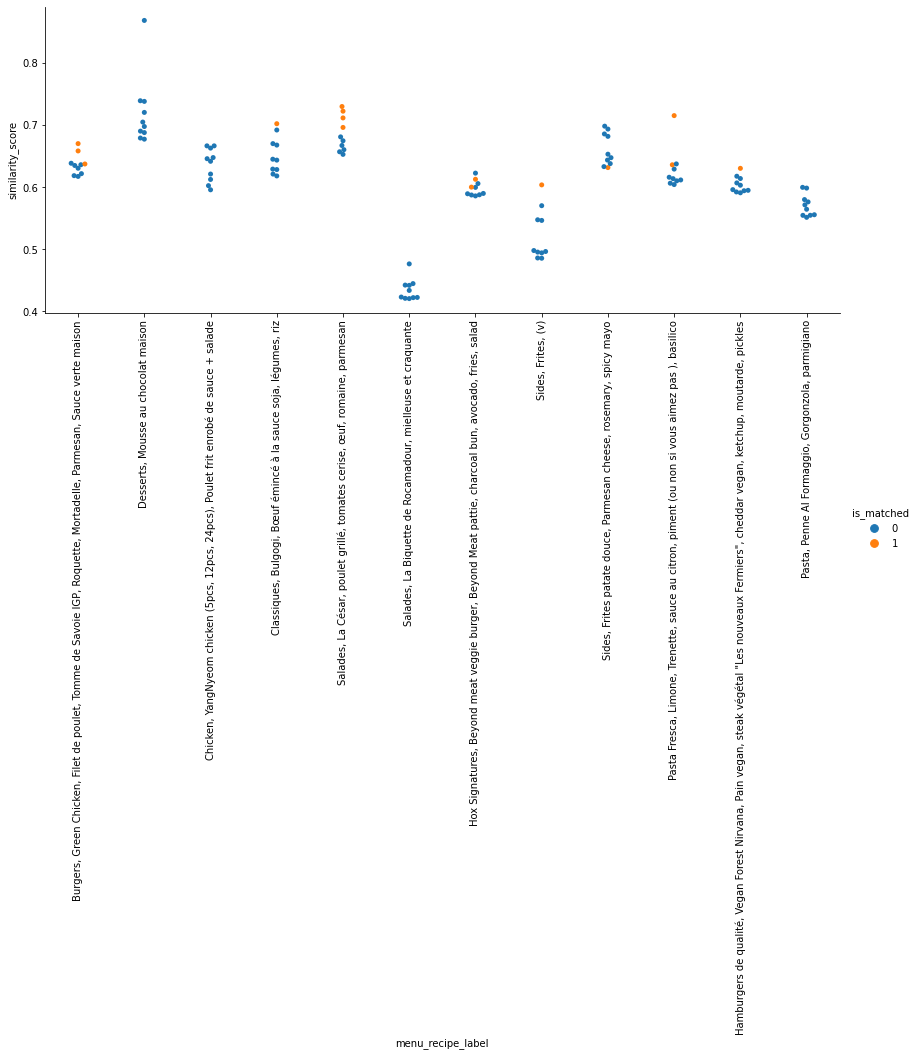

In [122]:
fig = sns.catplot(data = data_res, x = 'menu_recipe_label', y = 'similarity_score', hue = 'is_matched', kind = 'swarm', aspect = 3)
fig.set_xticklabels(rotation=90);

In [123]:
print("Number of good matchings among outputs with rank 1 :")
data_res[(data_res['similarity_rank']==1) & (data_res['is_matched']==1)].shape[0]

Number of good matchings among outputs with rank 1 :


6

In [126]:
df_tmp = pd.DataFrame(data_res.groupby('menu_recipe_id')['is_matched'].agg(sum))
df_tmp['is_matched'] = df_tmp['is_matched'].apply(lambda x: x if x==0 else 1)
df_tmp.head()

,is_matched
menu_recipe_id,
"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",1
"Chicken, YangNyeom chicken (5pcs, 12pcs, 24pcs), Poulet frit enrobé de sauce + salade",0
"Classiques, Bulgogi, Bœuf émincé à la sauce soja, légumes, riz",1
"Desserts, Mousse au chocolat maison",0
"Hamburgers de qualité, Vegan Forest Nirvana, Pain vegan, steak végétal ""Les nouveaux Fermiers"", cheddar vegan, ketchup, moutarde, pickles",1


In [127]:
print("Number of good matchings among outputs with rank between 1 and 10 :")
df_tmp[df_tmp['is_matched']==1].shape[0]


Number of good matchings among outputs with rank between 1 and 10 :


8

**Conclusion for the 7t database translated in french with french NLP model :**  
- 6/12 menu recipes are well matched at rank 1
- 8/12 menu recipes are well matched at rank <=10

Let's have now a quick look at predictions for menu recipes which could not be matched by hand to 7t recipes

In [129]:
menu_data_nomatch = menu_data[menu_data['Closest 7t recipe by hand']=='no match']
print("Number of queries = ", menu_data_nomatch.shape[0])

Number of queries =  26


In [141]:
dict_res2 = {}

# Find the closest 10 recipes of the (7t) corpus for each query recipe based on cosine similarity
for index, row in menu_data_nomatch.iterrows():
    query = row['Menu all']           # Menu recipes are labeled by their titles, subtitles, and ingredients
    query_embedding = model.encode(query, convert_to_tensor=True)
    
    # We use util.semantic_search to perform cosine similarty + topk
    hits = util.semantic_search(query_embedding, seven_fullname_embeddings_fr, top_k=10)
    hits = hits[0]      #Get the hits for the first query
    
    # Store results in a dictionary
    for k, hit in enumerate(hits):
        seven_recipe_fr = seven_fullname_recipes_fr[hit['corpus_id']]
        seven_recipe_en = seven_data[seven_data['name_with_ingredients_fr']==seven_recipe_fr]['title_raw'].values[0]
       
        closest_seven = row['Closest 7t recipe by hand']
        matched_idx = 0      # only menu recipes with could not be matched by hand with 7t recipes have considered here
        
        # For each menu recipe (index) and hit (k), store menu_recipe_id, menu_recipe_label, jow_guess, similarity_rank, similary_score, is_matched
        dict_res2[str(index)+'_'+str(k)] = [query, query, seven_recipe_en, k+1, hit['score'], matched_idx]   


In [142]:
data_res2 = pd.DataFrame.from_dict(dict_res2, orient = 'index', \
                                  columns = ['menu_recipe_id', 'menu_recipe_label', '7t_guess', 'similarity_rank', 'similarity_score', 'is_matched'])\
                                  .reset_index(drop = True)

data_res2

,menu_recipe_id,menu_recipe_label,7t_guess,similarity_rank,similarity_score,is_matched
0,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",chocolate dessert fondue,1,0.723942,0
1,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",easy chocolate ganache recipe,2,0.692798,0
2,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",chocolate dessert fondue recipe,3,0.680716,0
3,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",chocolate delight pie recipe,4,0.679741,0
4,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",chocolate fudge,5,0.677852,0
...,...,...,...,...,...,...
255,"Dessert, Baba au Rhum","Dessert, Baba au Rhum",hot buttered rum mix,6,0.559591,0
256,"Dessert, Baba au Rhum","Dessert, Baba au Rhum",sour cream fruit dip,7,0.553516,0
257,"Dessert, Baba au Rhum","Dessert, Baba au Rhum",sucre a la creme,8,0.553435,0
258,"Dessert, Baba au Rhum","Dessert, Baba au Rhum",candy bar shake,9,0.548402,0


Sometimes predictions are reasonable, sometimes they are not. Difficult to tell more now.

## Repeat for a NLP model working in french+english (without translating the 7t database in french and without translating the menu recipes in english)

In [143]:
model_enfr =  SentenceTransformer("symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli")

Calcule the recipes' embeddings




In [160]:
t0 = time()
seven_fullname_recipes_en = list(seven_data['name_with_ingredients'].values)
seven_fullname_embeddings_en = model_enfr.encode(seven_fullname_recipes_en, convert_to_tensor=True)
print("Time lapse for 7tomorrow recipes' embedding (s) = ", time()-t0)

Time lapse for 7tomorrow recipes' embedding (s) =  10.748023509979248


Run the NLP model

In [161]:
dict_res_en = {}

# Find the closest 10 recipes of the (7t) corpus for each query recipe based on cosine similarity
for index, row in menu_data_withmatch.iterrows():
    query = row['Menu all']           # Menu recipes are labeled by their titles, subtitles, and ingredients
    print("\n======================\n")
    query_embedding = model_enfr.encode(query, convert_to_tensor=True)
    
    # We use util.semantic_search to perform cosine similarty + topk
    printmd("**Query : "+query+"**")
    printmd("**Closest 7t recipe (by hand) : "+row['Closest 7t recipe by hand']+"**")
    print("\nTop 10 most similar recipes in 7t:")
    hits = util.semantic_search(query_embedding, seven_fullname_embeddings_en, top_k=10)
    hits = hits[0]      #Get the hits for the first query
    
    for k, hit in enumerate(hits):
        seven_recipe = seven_fullname_recipes_en[hit['corpus_id']]
        seven_recipe_title = seven_data[seven_data['name_with_ingredients']==seven_recipe]['title_raw'].values[0]
        print(k+1, ") ", seven_recipe_title, "(Score: {:.4f})".format(hit['score']))
        print('--> ingredients = ', list(seven_data[seven_data['name_with_ingredients']==seven_recipe]['ingredient_basics']))

    # Store results in a dictionary
    for k, hit in enumerate(hits):
        seven_recipe = seven_fullname_recipes_en[hit['corpus_id']]
        seven_recipe_title = seven_data[seven_data['name_with_ingredients']==seven_recipe]['title_raw'].values[0]
        closest_seven = row['Closest 7t recipe by hand']
        
        if closest_seven[0]=='[':       # To detect lists because they have been converted to strings. Bad, Bad!
            matched_idx = 1 if seven_recipe_title in closest_seven else 0
        else:
            matched_idx = 1 if seven_recipe_title==closest_seven else 0

        # For each menu recipe (index) and hit (k), store menu_recipe_id, menu_recipe_label, jow_guess, similarity_rank, similary_score, is_matched
        dict_res_en[str(index)+'_'+str(k)] = [query, query, seven_recipe_title, k+1, hit['score'], matched_idx]   


**Query : Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison**

**Closest 7t recipe (by hand) : ['awesome turkey burgers', 'blue cheese stuffed turkey burgers', 'chicken & broccoli burgers', 'greek burgers', 'spinach feta turkey burgers']**


Top 10 most similar recipes in 7t:
1 )  red, white & blue burger topper (Score: 0.7533)
--> ingredients =  ['cheese, salad dressing, spice']
2 )  spinach feta turkey burgers (Score: 0.7499)
--> ingredients =  ['salad dressing, ground turkey, seed, cheese, spinach, spice']
3 )  chicken & broccoli burgers (Score: 0.7300)
--> ingredients =  ['chicken, cheese, broccoli']
4 )  barbecue burger topping recipe (Score: 0.7156)
--> ingredients =  ['onion, sauce, salad dressing']
5 )  turkey gyro burgers (Score: 0.7085)
--> ingredients =  ['ground turkey, spice']
6 )  greek burgers (Score: 0.7019)
--> ingredients =  ['ground turkey, cheese, oil, spice']
7 )  asian turkey burgers (Score: 0.7008)
--> ingredients =  ['ground turkey, onion, spice, soy sauce  soy']
8 )  grilled barbecued brie (Score: 0.6963)
--> ingredients =  ['cheese, sauce, nut']
9 )  saucy foil-pack barbecue ribs (Score: 0.6932)
--> ingredients =  ['marmalade, spice, sauce, pork']
10 )  lea & perrins pork loin roast (Score: 0.679

**Query : Desserts, Mousse au chocolat maison**

**Closest 7t recipe (by hand) : ['chocolate mousse', 'chocolate dream mousse', 'raw chocolate mousse, lactose free']**


Top 10 most similar recipes in 7t:
1 )  atholl brose dessert recipe (Score: 0.7054)
--> ingredients =  ['cream']
2 )  white chocolate shot (Score: 0.6846)
--> ingredients =  ['ice cream, chocolate, cream']
3 )  chocolate dessert fondue recipe (Score: 0.6838)
--> ingredients =  ['chocolate, milk, cream']
4 )  chocolate cake batter mousse (Score: 0.6811)
--> ingredients =  ['cream']
5 )  coconut ice cream/gelato (Score: 0.6782)
--> ingredients =  ['confectionery, milk, cream']
6 )  liqueur base (Score: 0.6686)
--> ingredients =  ['milk, cream']
7 )  marshmallow fluff chocolate mousse (Score: 0.6561)
--> ingredients =  ['candy, cream, vanilla extract']
8 )  cioccolato e cocco (Score: 0.6495)
--> ingredients =  ['confectionery, chocolate, milk, cream']
9 )  chocolate truffles (with or withut alcohol) (Score: 0.6486)
--> ingredients =  ['milk, cream']
10 )  chocolate ganache (Score: 0.6477)
--> ingredients =  ['candy, cream, butter']




**Query : Chicken, YangNyeom chicken (5pcs, 12pcs, 24pcs), Poulet frit enrobé de sauce + salade**

**Closest 7t recipe (by hand) : korean bbq chicken**


Top 10 most similar recipes in 7t:
1 )  broiled/grilled marinated chicken (gai y recipe (Score: 0.8801)
--> ingredients =  ['soy sauce  soy, soup, sauce, lime juice, spice']
2 )  broiled or grilled marinated chicken (gai yang) (Score: 0.8671)
--> ingredients =  ['soy sauce  soy, soup, sauce, lime juice, spice']
3 )  chicken satay recipe (Score: 0.8599)
--> ingredients =  ['chicken']
4 )  ranch chicken bites (Score: 0.8532)
--> ingredients =  ['chicken, cream, salad dressing']
5 )  bbq chicken (Score: 0.8450)
--> ingredients =  ['chicken, sauce, salad dressing']
6 )  chaunanay's grilled chicken (Score: 0.8423)
--> ingredients =  ['chicken, sauce, salad dressing']
7 )  bbq chicken wings recipe (Score: 0.8309)
--> ingredients =  ['chicken, sauce']
8 )  skillet chicken parmesan (Score: 0.8284)
--> ingredients =  ['sauce, chicken, cheese, oil']
9 )  beef or chicken fajitas recipe (Score: 0.8273)
--> ingredients =  ['chicken']
10 )  baked chicken with pineapple (Score: 0.8263)
--> ingredien

**Query : Classiques, Bulgogi, Bœuf émincé à la sauce soja, légumes, riz**

**Closest 7t recipe (by hand) : beef bulgogi(korean marinated beef)**


Top 10 most similar recipes in 7t:
1 )  herb-roasted vegetables (Score: 0.7818)
--> ingredients =  ['vegetable, cheese, salad dressing']
2 )  mediterranean grilled vegetables (Score: 0.7720)
--> ingredients =  ['pepper, tomato, vegetable']
3 )  bbq pork kebabs (Score: 0.7432)
--> ingredients =  ['tomato sauce, soy sauce  soy, oil, pork, vinegar']
4 )  ranch vegetables (Score: 0.7419)
--> ingredients =  ['vegetable, oil, salad dressing']
5 )  marinated vegetables (Score: 0.7351)
--> ingredients =  ['vinegar, mustard, oil, vegetable, spice']
6 )  roasted vegetables (Score: 0.7317)
--> ingredients =  ['vegetable, cheese, salad dressing']
7 )  tropical fruit kebabs with orange maple coconut dipping sauce (Score: 0.7233)
--> ingredients =  ['syrup, orange juice, pineapple, confectionery, mango nectar, yogurt']
8 )  grilled brussels sprouts (Score: 0.7201)
--> ingredients =  ['oil, brussels sprout, dill weed, butter, spice']
9 )  crunchy baked vegetables (Score: 0.7105)
--> ingredients =  [

**Query : Salades, La César, poulet grillé, tomates cerise, œuf, romaine, parmesan**

**Closest 7t recipe (by hand) : ['better-for-you grilled chicken caesar salad', 'favorite grilled chicken caesar salad', 'grilled chicken a la caesar', 'grilled chicken caesar salad']**


Top 10 most similar recipes in 7t:
1 )  buffalo potato salad (Score: 0.8254)
--> ingredients =  ['chicken, pickle, salad dressing, fresh red onion, potato, celery, spice']
2 )  roasted vegetables (Score: 0.7712)
--> ingredients =  ['vegetable, cheese, salad dressing']
3 )  garlic potato tapa (Score: 0.7658)
--> ingredients =  ['salad dressing, mustard, onion, potato, spice']
4 )  tarragon chicken salad (Score: 0.7599)
--> ingredients =  ['chicken, lemon juice, salad dressing, mustard, fresh red onion, celery, spice']
5 )  pesto presto (Score: 0.7592)
--> ingredients =  ['cheese, salad dressing, spice']
6 )  mock caesar salad (Score: 0.7546)
--> ingredients =  ['vinegar, lettuce, oil, cheese, spice']
7 )  fierce sauce (Score: 0.7545)
--> ingredients =  ['salad dressing, tomato sauce, spice, yogurt, vinegar']
8 )  pecan chicken salad (Score: 0.7535)
--> ingredients =  ['chicken, salad dressing, apple, grape, pineapple juice, celery, nut']
9 )  calcutta chicken and rice salad (Score: 0.7

**Query : Salades, La Biquette de Rocamadour, mielleuse et craquante**

**Closest 7t recipe (by hand) : ['waldorf goat cheese salad']**


Top 10 most similar recipes in 7t:
1 )  rumbledethumps (Score: 0.6333)
--> ingredients =  ['cabbage, cheese, butter, potato, turnip']
2 )  cheddar shortbread (Score: 0.6225)
--> ingredients =  ['mustard, wheat flour, cheese, butter, spice']
3 )  tangy broccoli - low carb (Score: 0.6072)
--> ingredients =  ['broccoli, mustard, horseradish, salad dressing']
4 )  golden slaw (Score: 0.5996)
--> ingredients =  ['salad dressing, mustard, cabbage, carrot, parsley, vinegar']
5 )  crispy turnip 'fries' (Score: 0.5932)
--> ingredients =  ['turnip, cheese, oil, spice']
6 )  garlic potato tapa (Score: 0.5833)
--> ingredients =  ['salad dressing, mustard, onion, potato, spice']
7 )  dill-cucumber sauce (Score: 0.5782)
--> ingredients =  ['pickle, salad dressing, cream, dill weed, spice, shallot']
8 )  sweet & white potato spears (Score: 0.5761)
--> ingredients =  ['salad dressing, sweet potato, cheese, parsley, potato']
9 )  german potato salad (Score: 0.5730)
--> ingredients =  ['salad dressing,

**Query : Hox Signatures, Beyond meat veggie burger, Beyond Meat pattie, charcoal bun, avocado, fries, salad**

**Closest 7t recipe (by hand) : ['amara veggie burgers', 'the woodward veggie burger']**


Top 10 most similar recipes in 7t:
1 )  red, white & blue burger topper (Score: 0.7560)
--> ingredients =  ['cheese, salad dressing, spice']
2 )  spinach feta turkey burgers (Score: 0.7207)
--> ingredients =  ['salad dressing, ground turkey, seed, cheese, spinach, spice']
3 )  greek burgers (Score: 0.7136)
--> ingredients =  ['ground turkey, cheese, oil, spice']
4 )  barbecue burger topping recipe (Score: 0.6977)
--> ingredients =  ['onion, sauce, salad dressing']
5 )  tofu burgers (Score: 0.6844)
--> ingredients =  ['soy sauce  soy, oat, tofu, oil, sauce, mustard, spice']
6 )  asian turkey burgers (Score: 0.6745)
--> ingredients =  ['ground turkey, onion, spice, soy sauce  soy']
7 )  turkey gyro burgers (Score: 0.6742)
--> ingredients =  ['ground turkey, spice']
8 )  awesome turkey burgers (Score: 0.6625)
--> ingredients =  ['ground turkey, cranberry, cheese']
9 )  zesty parmesan croutons (Score: 0.6574)
--> ingredients =  ['cheese, wheat flour, salad dressing']
10 )  blue cheese stu

**Query : Sides, Frites, (v)**

**Closest 7t recipe (by hand) : perfectly simple french fries**


Top 10 most similar recipes in 7t:
1 )  another allspice substitute (halal) (Score: 0.4164)
--> ingredients =  ['spice']
2 )  western spice mix (Score: 0.4105)
--> ingredients =  ['spice']
3 )  berbere (Score: 0.4094)
--> ingredients =  ['spice']
4 )  blueberry waffles (Score: 0.4081)
--> ingredients =  ['blueberry, spice']
5 )  orange-ginger spread (Score: 0.4050)
--> ingredients =  ['marmalade, pineapple, spice']
6 )  hawaiij spice mix (Score: 0.4031)
--> ingredients =  ['spice']
7 )  herbed vinaigrette (Score: 0.4016)
--> ingredients =  ['vinegar, mustard, oil, spice']
8 )  gingeradish (Score: 0.3979)
--> ingredients =  ['spice, vinegar']
9 )  baharat spice blend (Score: 0.3907)
--> ingredients =  ['spice']
10 )  quatre epices (Score: 0.3904)
--> ingredients =  ['spice']




**Query : Sides, Frites patate douce, Parmesan cheese, rosemary, spicy mayo**

**Closest 7t recipe (by hand) : ['sweet potato fries', 'sweet-hot bbq tater fries', 'sweet potato fries with bbq mayo']**


Top 10 most similar recipes in 7t:
1 )  feta mayonnaise (Score: 0.7424)
--> ingredients =  ['parsley, cheese, salad dressing, spice']
2 )  pesto mayonnaise (Score: 0.7206)
--> ingredients =  ['cheese, oil, salad dressing, spice']
3 )  creamy pea & pesto tortellini (Score: 0.7153)
--> ingredients =  ['chicken, sauce, cream, cheese, pea']
4 )  sweet & white potato spears (Score: 0.7152)
--> ingredients =  ['salad dressing, sweet potato, cheese, parsley, potato']
5 )  mashed potatoes, pears and leeks (Score: 0.7150)
--> ingredients =  ['potato, leek, margarine, pear']
6 )  potato and vegetable strata (Score: 0.7135)
--> ingredients =  ['milk, denny, wheat flour, cheese, spinach, spice, egg']
7 )  hot cherry pepper mayonnaise (Score: 0.7124)
--> ingredients =  ['cherry, salad dressing, spice']
8 )  chipotle mayonnaise (Score: 0.7103)
--> ingredients =  ['cream, sauce, salad dressing, spice']
9 )  cheddar shortbread (Score: 0.7099)
--> ingredients =  ['mustard, wheat flour, cheese, butter,

**Query : Pasta Fresca, Limone, Trenette, sauce au citron, piment (ou non si vous aimez pas ), basilico**

**Closest 7t recipe (by hand) : ['lemon basil spaghetti', 'lemon butter parmesan linguini']**


Top 10 most similar recipes in 7t:
1 )  tangy fajita marinade (Score: 0.7352)
--> ingredients =  ['pineapple juice, lime juice, soy sauce  soy, spice']
2 )  santa barbara tri tip marinade (Score: 0.7164)
--> ingredients =  ['soy sauce  soy, sugar, pineapple juice, onion, spice, vinegar']
3 )  pasta florentine (Score: 0.7088)
--> ingredients =  ['spinach, cheese, oil, spice']
4 )  plum & papaya salsa (Score: 0.7077)
--> ingredients =  ['plum, sugar, pepper, onion, spice, papaya, vinegar']
5 )  papaya mango salsa (Score: 0.7058)
--> ingredients =  ['pepper, mango nectar, lime juice, papaya, spice']
6 )  spicy broccoli (Score: 0.7014)
--> ingredients =  ['broccoli, oil, spice']
7 )  cilantro lime pesto (Score: 0.6999)
--> ingredients =  ['oil, nut, cheese, parsley, lime juice, spice']
8 )  aqua negra marinade (Score: 0.6943)
--> ingredients =  ['pineapple juice, lime juice, soy sauce  soy, spice']
9 )  spicy garlic panini sauce (Score: 0.6884)
--> ingredients =  ['salad dressing, spice']

**Query : Hamburgers de qualité, Vegan Forest Nirvana, Pain vegan, steak végétal "Les nouveaux Fermiers", cheddar vegan, ketchup, moutarde, pickles**

**Closest 7t recipe (by hand) : tofu burgers**


Top 10 most similar recipes in 7t:
1 )  vegan horchata (Score: 0.5534)
--> ingredients =  ['nut, syrup, rice, vanilla extract']
2 )  vegan tex mex rice (Score: 0.5385)
--> ingredients =  ['soup, oil, rice, spice']
3 )  vegan potatoes (Score: 0.5248)
--> ingredients =  ['oil, pepper, potato, mushroom, spice']
4 )  vegan gluten-free chocolate coconut peanut truffles! (Score: 0.5246)
--> ingredients =  ['confectionery, syrup, peanut butter, cocoa']
5 )  wild grape starter (Score: 0.5233)
--> ingredients =  ['grape, wheat flour']
6 )  vegan peanut butter balls (Score: 0.5196)
--> ingredients =  ['oat, sweetener, peanut butter, confectionery']
7 )  saffron skillet-baked rice (Score: 0.4951)
--> ingredients =  ['vegetable, butter, parsley, rice, spice']
8 )  raw vegan chocolate ganache (Score: 0.4910)
--> ingredients =  ['confectionery, sweetener, cocoa']
9 )  natural garlic jerky (Score: 0.4892)
--> ingredients =  ['beef, confectionery, spice']
10 )  cheese wafers (Score: 0.4867)
--> ingre

**Query : Pasta, Penne Al Formaggio, Gorgonzola, parmigiano**

**Closest 7t recipe (by hand) : roquefort pasta**


Top 10 most similar recipes in 7t:
1 )  pasta florentine (Score: 0.7362)
--> ingredients =  ['spinach, cheese, oil, spice']
2 )  ravioli primavera (Score: 0.7197)
--> ingredients =  ['vegetable, cheese, sauce']
3 )  italian seasoning mix (Score: 0.6977)
--> ingredients =  ['spice']
4 )  pasta blend (Score: 0.6897)
--> ingredients =  ['spice']
5 )  spicy garlic panini sauce (Score: 0.6815)
--> ingredients =  ['salad dressing, spice']
6 )  italian butter (Score: 0.6761)
--> ingredients =  ['butter, spice']
7 )  ww 2 points - pizza nachos (Score: 0.6698)
--> ingredients =  ['corn, cheese, tomato sauce, spice']
8 )  italian vegetable dip (Score: 0.6679)
--> ingredients =  ['cream, salad dressing']
9 )  italian seasoning (Score: 0.6643)
--> ingredients =  ['parsley, spice']
10 )  italian blend spice mix (Score: 0.6603)
--> ingredients =  ['spice']


In [162]:
data_res_en = pd.DataFrame.from_dict(dict_res_en, orient = 'index', \
                                  columns = ['menu_recipe_id', 'menu_recipe_label', '7t_guess', 'similarity_rank', 'similarity_score', 'is_matched'])\
                                  .reset_index(drop = True)

data_res_en

,menu_recipe_id,menu_recipe_label,7t_guess,similarity_rank,similarity_score,is_matched
0,"Burgers, Green Chicken, Filet de poulet, Tomme...","Burgers, Green Chicken, Filet de poulet, Tomme...","red, white & blue burger topper",1,0.753265,0
1,"Burgers, Green Chicken, Filet de poulet, Tomme...","Burgers, Green Chicken, Filet de poulet, Tomme...",spinach feta turkey burgers,2,0.749861,1
2,"Burgers, Green Chicken, Filet de poulet, Tomme...","Burgers, Green Chicken, Filet de poulet, Tomme...",chicken & broccoli burgers,3,0.729995,1
3,"Burgers, Green Chicken, Filet de poulet, Tomme...","Burgers, Green Chicken, Filet de poulet, Tomme...",barbecue burger topping recipe,4,0.715635,0
4,"Burgers, Green Chicken, Filet de poulet, Tomme...","Burgers, Green Chicken, Filet de poulet, Tomme...",turkey gyro burgers,5,0.708515,0
...,...,...,...,...,...,...
115,"Pasta, Penne Al Formaggio, Gorgonzola, parmigiano","Pasta, Penne Al Formaggio, Gorgonzola, parmigiano",italian butter,6,0.676118,0
116,"Pasta, Penne Al Formaggio, Gorgonzola, parmigiano","Pasta, Penne Al Formaggio, Gorgonzola, parmigiano",ww 2 points - pizza nachos,7,0.669762,0
117,"Pasta, Penne Al Formaggio, Gorgonzola, parmigiano","Pasta, Penne Al Formaggio, Gorgonzola, parmigiano",italian vegetable dip,8,0.667918,0
118,"Pasta, Penne Al Formaggio, Gorgonzola, parmigiano","Pasta, Penne Al Formaggio, Gorgonzola, parmigiano",italian seasoning,9,0.664333,0


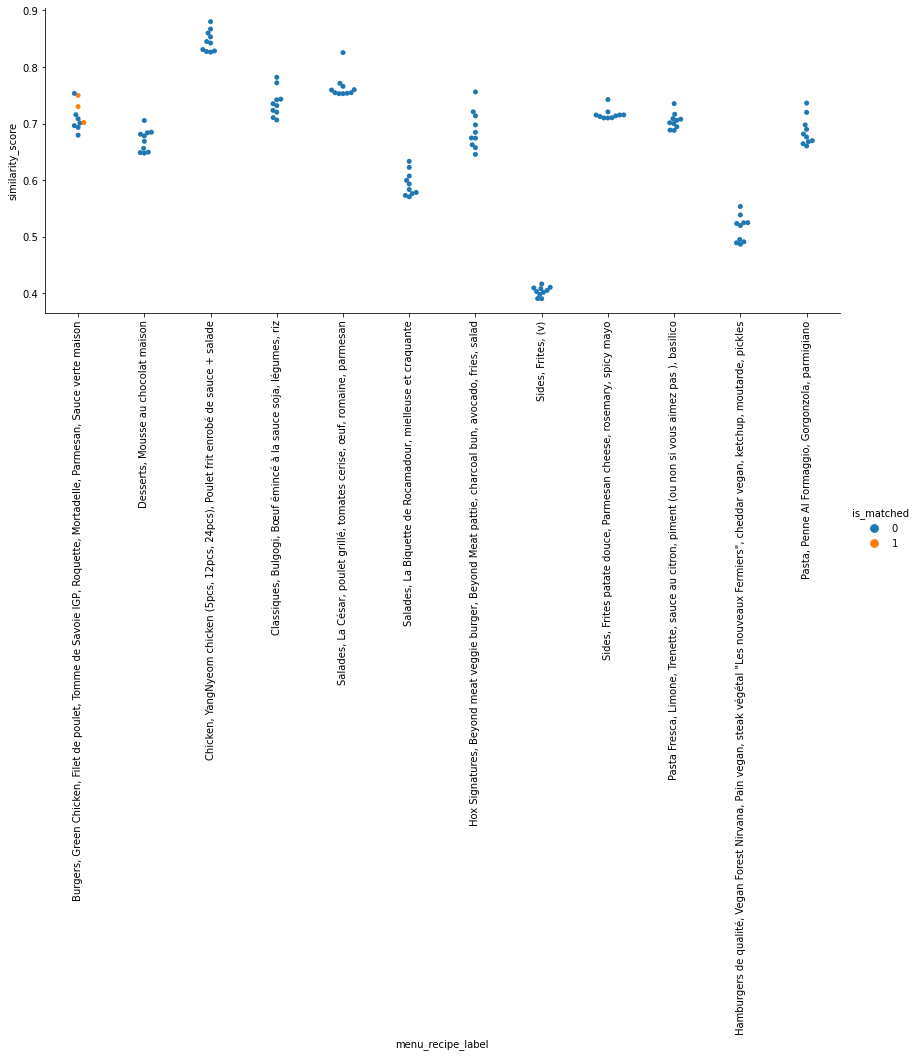

In [163]:
fig = sns.catplot(data = data_res_en, x = 'menu_recipe_label', y = 'similarity_score', hue = 'is_matched', kind = 'swarm', aspect = 3)
fig.set_xticklabels(rotation=90);

In [164]:
print("Number of good matchings among outputs with rank 1 :")
data_res_en[(data_res_en['similarity_rank']==1) & (data_res_en['is_matched']==1)].shape[0]

Number of good matchings among outputs with rank 1 :


0

In [165]:
df_tmp = pd.DataFrame(data_res_en.groupby('menu_recipe_id')['is_matched'].agg(sum))
df_tmp['is_matched'] = df_tmp['is_matched'].apply(lambda x: x if x==0 else 1)
df_tmp.head()

,is_matched
menu_recipe_id,
"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",1
"Chicken, YangNyeom chicken (5pcs, 12pcs, 24pcs), Poulet frit enrobé de sauce + salade",0
"Classiques, Bulgogi, Bœuf émincé à la sauce soja, légumes, riz",0
"Desserts, Mousse au chocolat maison",0
"Hamburgers de qualité, Vegan Forest Nirvana, Pain vegan, steak végétal ""Les nouveaux Fermiers"", cheddar vegan, ketchup, moutarde, pickles",0


In [166]:
print("Number of good matchings among outputs with rank between 1 and 10 :")
df_tmp[df_tmp['is_matched']==1].shape[0]


Number of good matchings among outputs with rank between 1 and 10 :


1

**Conclusion for the french+english NLP model (7t database in english, menu recipes in french) :**  
- 0/12 menu recipes are well matched at rank 1
- 1/12 menu recipes are well matched at rank <=10

**Really bad ...**

## Repeat for a NLP model working in english only (keeping the 7t recipes in english and translating the menu recipes in english)

Translate the menu recipes in english

In [167]:
menu_data.head()

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle,Menu all
0,3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette...",Not yet handled,"['awesome turkey burgers', 'blue cheese stuffe...","Burgers, Green Chicken","Burgers, Green Chicken, Filet de poulet, Tomme..."
1,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"['chocolate mousse', 'chocolate dream mousse',...","Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison"
2,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,no match,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger"
3,17,Carte-in-seoul.png,Anju,Mandoo (6 pcs),Raviolis maison grillés au porc et légumes,no match,no match,"Anju, Mandoo (6 pcs)","Anju, Mandoo (6 pcs), Raviolis maison grillés ..."
4,18,Carte-in-seoul.png,Anju,Haemul Jeol,Galette de fruit mer,no match,no match,"Anju, Haemul Jeol","Anju, Haemul Jeol, Galette de fruit mer"


In [168]:
from textblob import TextBlob

def translate(s):
    try:
        res = str(TextBlob(s).translate(from_lang = 'fr', to = 'en'))   # Translation is done using Google Translate API
    except:    # when the translation API returns the input string unchanged
        res = s
    return res

menu_data['Menu Title_en'] = menu_data['Menu Title'].apply(translate)
menu_data['Menu Subtitle_en'] = menu_data['Menu Subtitle'].apply(translate)
menu_data['Menu Ingredients_en'] = menu_data['Menu Ingredients'].apply(translate)
menu_data.head()

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle,Menu all,Menu Title_en,Menu Subtitle_en,Menu Ingredients_en
0,3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette...",Not yet handled,"['awesome turkey burgers', 'blue cheese stuffe...","Burgers, Green Chicken","Burgers, Green Chicken, Filet de poulet, Tomme...",Burgers,Green Chicken,"Chicken fillet, Tomme de Savoie IGP, Roquette,..."
1,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"['chocolate mousse', 'chocolate dream mousse',...","Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Desserts,Homemade chocolate mousse,
2,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,no match,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",Desserts,Fondant Au Chocolat Artisan Boulanger,
3,17,Carte-in-seoul.png,Anju,Mandoo (6 pcs),Raviolis maison grillés au porc et légumes,no match,no match,"Anju, Mandoo (6 pcs)","Anju, Mandoo (6 pcs), Raviolis maison grillés ...",Anju,Mandoo (6 pcs),Grilled homemade pork and vegetable ravioli
4,18,Carte-in-seoul.png,Anju,Haemul Jeol,Galette de fruit mer,no match,no match,"Anju, Haemul Jeol","Anju, Haemul Jeol, Galette de fruit mer",Anju,Haemul Jeol,Seafood


In [169]:
def add_ingredients_en(row):
    if row['Menu Ingredients_en']=='':
        res = row['Menu Title_en'] + ", " + row['Menu Subtitle_en']
    else:
        res = row['Menu Title_en'] + ", " + row['Menu Subtitle_en'] + ", " + row['Menu Ingredients_en']
    return res

menu_data['Menu all_en'] = menu_data.apply(add_ingredients_en, axis = 1)
menu_data.head(8)

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle,Menu all,Menu Title_en,Menu Subtitle_en,Menu Ingredients_en,Menu all_en
0,3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette...",Not yet handled,"['awesome turkey burgers', 'blue cheese stuffe...","Burgers, Green Chicken","Burgers, Green Chicken, Filet de poulet, Tomme...",Burgers,Green Chicken,"Chicken fillet, Tomme de Savoie IGP, Roquette,...","Burgers, Green Chicken, Chicken fillet, Tomme ..."
1,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"['chocolate mousse', 'chocolate dream mousse',...","Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Desserts,Homemade chocolate mousse,,"Desserts, Homemade chocolate mousse"
2,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,no match,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",Desserts,Fondant Au Chocolat Artisan Boulanger,,"Desserts, Fondant Au Chocolat Artisan Boulanger"
3,17,Carte-in-seoul.png,Anju,Mandoo (6 pcs),Raviolis maison grillés au porc et légumes,no match,no match,"Anju, Mandoo (6 pcs)","Anju, Mandoo (6 pcs), Raviolis maison grillés ...",Anju,Mandoo (6 pcs),Grilled homemade pork and vegetable ravioli,"Anju, Mandoo (6 pcs), Grilled homemade pork an..."
4,18,Carte-in-seoul.png,Anju,Haemul Jeol,Galette de fruit mer,no match,no match,"Anju, Haemul Jeol","Anju, Haemul Jeol, Galette de fruit mer",Anju,Haemul Jeol,Seafood,"Anju, Haemul Jeol, Seafood"
5,19,Carte-in-seoul.png,Anju,Sewoo kkanpoong (8 pcs),Crevettes frites dans une sauce aigre douce,"['Crevettes teriyaki', 'Crevettes miel sésame']",no match,"Anju, Sewoo kkanpoong (8 pcs)","Anju, Sewoo kkanpoong (8 pcs), Crevettes frite...",Anju,Sewoo Kkanpoong (8 pcs),Fried shrimp in a sweet sour sauce,"Anju, Sewoo Kkanpoong (8 pcs), Fried shrimp in..."
6,20,Carte-in-seoul.png,Bibimbap,Dolsot bibimbap (en pierrade au choix),Bœuf,no match,no match,"Bibimbap, Dolsot bibimbap (en pierrade au choix)","Bibimbap, Dolsot bibimbap (en pierrade au choi...",bibimbap,Dolsot Bibimbap (in pierrade of your choice),Beef,"bibimbap, Dolsot Bibimbap (in pierrade of your..."
7,21,Carte-in-seoul.png,Chicken,"YangNyeom chicken (5pcs, 12pcs, 24pcs)",Poulet frit enrobé de sauce + salade,no match,korean bbq chicken,"Chicken, YangNyeom chicken (5pcs, 12pcs, 24pcs)","Chicken, YangNyeom chicken (5pcs, 12pcs, 24pcs...",Chicken,"Yangnyeom Chicken (5pcs, 12pcs, 24pcs)",Fried chicken coated with sauce + salad,"Chicken, Yangnyeom Chicken (5pcs, 12pcs, 24pcs..."


In [173]:
menu_data_withmatch = menu_data[menu_data['Closest 7t recipe by hand']!='no match']
print("Number of queries = ", menu_data_withmatch.shape[0])

Number of queries =  12


Import the model

In [202]:
#model_en =  SentenceTransformer("sentence-transformers/all-roberta-large-v1")
#model_en =  SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
#model_en =  SentenceTransformer("sentence-transformers/sentence-t5-base")
#model_en =  SentenceTransformer("sentence-transformers/gtr-t5-large")
model_en =  SentenceTransformer("sentence-transformers/sentence-t5-xl")

Calcule the recipes' embeddings




In [203]:
t0 = time()
seven_fullname_recipes_en = list(seven_data['name_with_ingredients'].values)
seven_fullname_embeddings_en2 = model_en.encode(seven_fullname_recipes_en, convert_to_tensor=True)
print("Time lapse for 7tomorrow recipes' embedding (s) = ", time()-t0)

Time lapse for 7tomorrow recipes' embedding (s) =  134.48061180114746


Run the NLP model

In [204]:
dict_res_en2 = {}

# Find the closest 10 recipes of the (7t) corpus for each query recipe based on cosine similarity
for index, row in menu_data_withmatch.iterrows():
    query = row['Menu all_en']           # Menu recipes are labeled by their titles, subtitles, and ingredients
    print("\n======================\n")
    query_embedding = model_en.encode(query, convert_to_tensor=True)
    
    # We use util.semantic_search to perform cosine similarty + topk
    printmd("**Query : "+query+"**")
    printmd("**Closest 7t recipe (by hand) : "+row['Closest 7t recipe by hand']+"**")
    print("\nTop 10 most similar recipes in 7t:")
    hits = util.semantic_search(query_embedding, seven_fullname_embeddings_en2, top_k=10)
    hits = hits[0]      #Get the hits for the first query
    
    for k, hit in enumerate(hits):
        seven_recipe = seven_fullname_recipes_en[hit['corpus_id']]
        seven_recipe_title = seven_data[seven_data['name_with_ingredients']==seven_recipe]['title_raw'].values[0]
        print(k+1, ") ", seven_recipe_title, "(Score: {:.4f})".format(hit['score']))
        print('--> ingredients = ', list(seven_data[seven_data['name_with_ingredients']==seven_recipe]['ingredient_basics']))

    # Store results in a dictionary
    for k, hit in enumerate(hits):
        seven_recipe = seven_fullname_recipes_en[hit['corpus_id']]
        seven_recipe_title = seven_data[seven_data['name_with_ingredients']==seven_recipe]['title_raw'].values[0]
        closest_seven = row['Closest 7t recipe by hand']
        
        if closest_seven[0]=='[':       # To detect lists because they have been converted to strings. Bad, Bad!
            matched_idx = 1 if seven_recipe_title in closest_seven else 0
        else:
            matched_idx = 1 if seven_recipe_title==closest_seven else 0

        # For each menu recipe (index) and hit (k), store menu_recipe_id, menu_recipe_label, jow_guess, similarity_rank, similary_score, is_matched
        dict_res_en2[str(index)+'_'+str(k)] = [query, query, seven_recipe_title, k+1, hit['score'], matched_idx]   


**Query : Burgers, Green Chicken, Chicken fillet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Homemade green sauce**

**Closest 7t recipe (by hand) : ['awesome turkey burgers', 'blue cheese stuffed turkey burgers', 'chicken & broccoli burgers', 'greek burgers', 'spinach feta turkey burgers']**


Top 10 most similar recipes in 7t:
1 )  pesto chicken and potato patties (Score: 0.8524)
--> ingredients =  ['chicken, denny, cream, sauce, cheese, spice']
2 )  spinach feta turkey burgers (Score: 0.8307)
--> ingredients =  ['salad dressing, ground turkey, seed, cheese, spinach, spice']
3 )  chicken & broccoli burgers (Score: 0.8298)
--> ingredients =  ['chicken, cheese, broccoli']
4 )  creamy pesto gnocchi (Score: 0.8193)
--> ingredients =  ['chicken, milk, sauce, cheese, spinach, potato']
5 )  green turkey and cheese (Score: 0.8178)
--> ingredients =  ['spinach, cheese, ground turkey']
6 )  red, white & blue burger topper (Score: 0.8177)
--> ingredients =  ['cheese, salad dressing, spice']
7 )  chaunanay's grilled chicken (Score: 0.8145)
--> ingredients =  ['chicken, sauce, salad dressing']
8 )  pesto coated chicken skewers (Score: 0.8108)
--> ingredients =  ['sauce, chicken, oil']
9 )  pesto chicken salad (Score: 0.8105)
--> ingredients =  ['fresh red onion, chicken, sauce, salad d

**Query : Desserts, Homemade chocolate mousse**

**Closest 7t recipe (by hand) : ['chocolate mousse', 'chocolate dream mousse', 'raw chocolate mousse, lactose free']**


Top 10 most similar recipes in 7t:
1 )  milk chocolate peanut butter mousse (Score: 0.8775)
--> ingredients =  ['milk, peanut butter, cream, oil']
2 )  chocolate peanut butter mousse (Score: 0.8706)
--> ingredients =  ['milk, peanut butter, cream, oil']
3 )  chocolate cheesecake mousse (Score: 0.8668)
--> ingredients =  ['cheese, cocoa, honey']
4 )  chocolate cake batter mousse (Score: 0.8627)
--> ingredients =  ['cream']
5 )  melted ice cream mousse (Score: 0.8587)
--> ingredients =  ['ice cream, cream, cocoa']
6 )  chocolate soup with brownie croutons and mousse dessert (Score: 0.8517)
--> ingredients =  ['milk, cream']
7 )  chocolate dessert fondue (Score: 0.8464)
--> ingredients =  ['milk, candy, cream, butter, nut']
8 )  chocolate dessert fondue recipe (Score: 0.8391)
--> ingredients =  ['chocolate, milk, cream']
9 )  marshmallow fluff chocolate mousse (Score: 0.8374)
--> ingredients =  ['candy, cream, vanilla extract']
10 )  pumpkin pie mousse (Score: 0.8331)
--> ingredients =  

**Query : Chicken, Yangnyeom Chicken (5pcs, 12pcs, 24pcs), Fried chicken coated with sauce + salad**

**Closest 7t recipe (by hand) : korean bbq chicken**


Top 10 most similar recipes in 7t:
1 )  bbq chicken (Score: 0.8767)
--> ingredients =  ['chicken, sauce, salad dressing']
2 )  roast chicken & rice salad (Score: 0.8636)
--> ingredients =  ['chicken, salad dressing, grape, rice, nut']
3 )  chaunanay's grilled chicken (Score: 0.8543)
--> ingredients =  ['chicken, sauce, salad dressing']
4 )  korean bbq chicken (Score: 0.8523)
--> ingredients =  ['chicken, lemon juice, soy sauce  soy, oil, sugar, seed, honey, rice, spice']
5 )  pat's own marinated chicken (Score: 0.8453)
--> ingredients =  ['chicken, salad dressing']
6 )  chicken salad (Score: 0.8445)
--> ingredients =  ['chicken, salad dressing, ice cream, grape, dill weed, celery, nut']
7 )  asian chicken salad (Score: 0.8436)
--> ingredients =  ['chicken, lemon juice, soy sauce  soy, salad dressing, oil, onion, spice, nut']
8 )  dak bulgogi (korean chicken bulgogi) (Score: 0.8433)
--> ingredients =  ['lemon juice, soy sauce  soy, soup, oil, sugar, seed, honey, rice, spice']
9 )  pest

**Query : Classic, Bulgogi, Successful beef in soy sauce, vegetables, rice**

**Closest 7t recipe (by hand) : beef bulgogi(korean marinated beef)**


Top 10 most similar recipes in 7t:
1 )  beef bulgogi(korean marinated beef) (Score: 0.8907)
--> ingredients =  ['soy sauce  soy, oil, sugar, seed, beef, onion, spice']
2 )  dak bulgogi (korean chicken bulgogi) (Score: 0.8402)
--> ingredients =  ['lemon juice, soy sauce  soy, soup, oil, sugar, seed, honey, rice, spice']
3 )  rice bowl (Score: 0.8194)
--> ingredients =  ['vegetable, rice']
4 )  fried rice (Score: 0.8194)
--> ingredients =  ['onion, soy sauce  soy, rice, spice']
5 )  marinated flank steak (Score: 0.8167)
--> ingredients =  ['vinegar, soy sauce  soy, oil, sugar, seed, honey, beef, onion, rice, spice']
6 )  panang beef or beef in red curry peanuts sauce (Score: 0.8154)
--> ingredients =  ['sugar']
7 )  mongolian beef recipe (Score: 0.8139)
--> ingredients =  ['beef']
8 )  chicken, beef, pork or shrimp lo mein recipe (Score: 0.8055)
--> ingredients =  ['beef']
9 )  cheesy rice (Score: 0.8051)
--> ingredients =  ['cheese, cream, rice, spice']
10 )  korean bbq chicken (Score:

**Query : Salads, The Caesar, Grilled chicken, cherry, egg, Roman tomatoes, parmesan**

**Closest 7t recipe (by hand) : ['better-for-you grilled chicken caesar salad', 'favorite grilled chicken caesar salad', 'grilled chicken a la caesar', 'grilled chicken caesar salad']**


Top 10 most similar recipes in 7t:
1 )  grilled chicken caesar salad (Score: 0.9242)
--> ingredients =  ['chicken, salad dressing, lettuce, crouton, cheese']
2 )  grilled chicken a la caesar (Score: 0.9184)
--> ingredients =  ['chicken, salad dressing, lettuce, crouton, cheese']
3 )  better-for-you grilled chicken caesar salad (Score: 0.9096)
--> ingredients =  ['chicken, salad dressing, lettuce, crouton, cheese']
4 )  favorite grilled chicken caesar salad (Score: 0.9065)
--> ingredients =  ['chicken, salad dressing, lettuce, crouton, cheese']
5 )  tangy caesar salad (Score: 0.8580)
--> ingredients =  ['lemon juice, lettuce, salad dressing, crouton, cheese, spice']
6 )  tarragon chicken salad ii (Score: 0.8567)
--> ingredients =  ['chicken, salad dressing, raisin, parsley, fresh red onion, celery, spice']
7 )  summer chicken salad (Score: 0.8566)
--> ingredients =  ['chicken, salad dressing, grape, celery, nut']
8 )  pesto chicken salad (Score: 0.8508)
--> ingredients =  ['fresh red o

**Query : Salads, The Rocamadour biquette, honeyed and crisp**

**Closest 7t recipe (by hand) : ['waldorf goat cheese salad']**


Top 10 most similar recipes in 7t:
1 )  radish salad with goat cheese (Score: 0.8509)
--> ingredients =  ['oil, cheese, honey, spinach, spice, radish, vinegar']
2 )  cranberry, feta and walnut salad (Score: 0.8468)
--> ingredients =  ['vinegar, lettuce, cranberry, oil, mustard, cheese, honey, spice, nut']
3 )  broccoli raisin cauliflower salad (Score: 0.8459)
--> ingredients =  ['vinegar, oil, raisin, nut, honey, cauliflower, spice, broccoli']
4 )  layered cheddar-fruit salad (Score: 0.8408)
--> ingredients =  ['salad dressing, lettuce, cream, peach, grape, cheese, honey, strawberry']
5 )  carrot and raisin salad (Score: 0.8379)
--> ingredients =  ['orange juice, lemon juice, salad dressing, confectionery, raisin, seed, carrot, honey']
6 )  almond raspberry tossed salad (Score: 0.8370)
--> ingredients =  ['vinegar, lettuce, raspberry, oil, honey, jam  preserve, nut']
7 )  balsamic salad dressing (Score: 0.8352)
--> ingredients =  ['lemon juice, oil, mustard, cheese, honey, spice, vine

**Query : Hox signatures, Beyond Meat Veggie Burger, Beyond Meat Pattie, Charcoal Bun, Avocado, Fries, Salad**

**Closest 7t recipe (by hand) : ['amara veggie burgers', 'the woodward veggie burger']**


Top 10 most similar recipes in 7t:
1 )  amara veggie burgers (Score: 0.8305)
--> ingredients =  ['peanut butter, wheat flour, seed, pepper, carrot, rice']
2 )  the woodward veggie burger (Score: 0.8215)
--> ingredients =  ['soy sauce  soy, oil, nut, seed, onion, rice, spice']
3 )  tofu burgers (Score: 0.8115)
--> ingredients =  ['soy sauce  soy, oat, tofu, oil, sauce, mustard, spice']
4 )  sweet potato fries (Score: 0.7972)
--> ingredients =  ['sweet potato, cheese, salad dressing']
5 )  tofu potato topper (Score: 0.7918)
--> ingredients =  ['tofu, chive, lemon juice']
6 )  vegan potatoes (Score: 0.7910)
--> ingredients =  ['oil, pepper, potato, mushroom, spice']
7 )  peanut burgers (Score: 0.7900)
--> ingredients =  ['oil, seed, dill weed, carrot, onion, parsley, celery, spice']
8 )  alex's vegan mushroom gravy (Score: 0.7861)
--> ingredients =  ['soy sauce  soy, oil, wheat flour, vegetable, onion, mushroom, spice']
9 )  sweet potato fries with bbq mayo (Score: 0.7852)
--> ingredient

**Query : Sides, Fries, (V)**

**Closest 7t recipe (by hand) : perfectly simple french fries**


Top 10 most similar recipes in 7t:
1 )  potato wedges (Score: 0.8142)
--> ingredients =  ['parsley, potato, cheese, salad dressing']
2 )  soup-er potato salad ww (Score: 0.8098)
--> ingredients =  ['potato, vegetable, salad dressing, vinegar']
3 )  potatoes and brussels sprouts with oil and vinegar (Score: 0.8005)
--> ingredients =  ['brussels sprout, potato, oil, vinegar']
4 )  mushrooms on the side (Score: 0.7963)
--> ingredients =  ['mushroom, butter']
5 )  carrot fries (Score: 0.7931)
--> ingredients =  ['dill weed, carrot, butter']
6 )  vidalia cheese dip (Score: 0.7928)
--> ingredients =  ['onion, cheese']
7 )  sweet potato fries (Score: 0.7926)
--> ingredients =  ['sweet potato, cheese, salad dressing']
8 )  french fry sauce (copycat) (Score: 0.7913)
--> ingredients =  ['sauce, salad dressing']
9 )  vinaigrette salad dressings (Score: 0.7913)
--> ingredients =  ['oil, vinegar']
10 )  mediterranean tomato side dish (Score: 0.7903)
--> ingredients =  ['onion, oil, grape, spice']


**Query : Sides, Sweet potato fries, Parmesan Cheese, Rosemary, Spicy Mayo**

**Closest 7t recipe (by hand) : ['sweet potato fries', 'sweet-hot bbq tater fries', 'sweet potato fries with bbq mayo']**


Top 10 most similar recipes in 7t:
1 )  sweet potato fries with bbq mayo (Score: 0.9210)
--> ingredients =  ['sweet potato, sauce, salad dressing']
2 )  sweet potato fries (Score: 0.9139)
--> ingredients =  ['sweet potato, cheese, salad dressing']
3 )  garlic & herb sweet potato fries with rouge-ranch dip (Score: 0.9056)
--> ingredients =  ['salad dressing, oil, mustard, sweet potato, spice']
4 )  dip for sweet potato fries (Score: 0.9050)
--> ingredients =  ['salad dressing, cream, honey, horseradish, spice']
5 )  creamy maple dip for sweet potato fries (Score: 0.8847)
--> ingredients =  ['syrup, salad dressing']
6 )  baked sweet potato wedges (Score: 0.8828)
--> ingredients =  ['sweet potato, parsley, cheese, salad dressing']
7 )  maple mayo for sweet potato fries (Score: 0.8822)
--> ingredients =  ['syrup, sugar, salad dressing']
8 )  roasted potato wedges with cilantro-lime mayonnaise (Score: 0.8677)
--> ingredients =  ['salad dressing, oil, cream, lime juice, spice, potato']
9 ) 

**Query : Pasta Fresca, Silt, Trenette, lemon sauce, pepper (or not if you don't like it), basilico**

**Closest 7t recipe (by hand) : ['lemon basil spaghetti', 'lemon butter parmesan linguini']**


Top 10 most similar recipes in 7t:
1 )  lemon basil spaghetti (Score: 0.8723)
--> ingredients =  ['lemon juice, noodle, oil, cheese, spice']
2 )  lemon butter parmesan linguini (Score: 0.8540)
--> ingredients =  ['lemon juice, noodle, cheese, butter, spice']
3 )  pasta florentine (Score: 0.8381)
--> ingredients =  ['spinach, cheese, oil, spice']
4 )  lemon penne & shrimp medley (Score: 0.8356)
--> ingredients =  ['crustacean, oil, pepper, cheese, spice']
5 )  lightened up creamy spinach fettucine (Score: 0.8309)
--> ingredients =  ['spinach, cheese, butter, spice']
6 )  shrimp and pasta primavera (Score: 0.8290)
--> ingredients =  ['sauce, crustacean, dill weed, cream']
7 )  homemade (fat free) pasta (Score: 0.8281)
--> ingredients =  ['wheat flour, egg']
8 )  pasta salad dressing (Score: 0.8262)
--> ingredients =  ['leek, lemon juice, salad dressing, honey, parsley']
9 )  simple cheese pasta sauce (Score: 0.8226)
--> ingredients =  ['milk, wheat flour, cheese, butter, spice']
10 )  e

**Query : Quality hamburgers, Vegan Forest Nirvana, Vegan bread, vegetable steak "new farmers", vegan cheddar, ketchup, mustard, pickles**

**Closest 7t recipe (by hand) : tofu burgers**


Top 10 most similar recipes in 7t:
1 )  amara veggie burgers (Score: 0.8538)
--> ingredients =  ['peanut butter, wheat flour, seed, pepper, carrot, rice']
2 )  vegan potatoes (Score: 0.8295)
--> ingredients =  ['oil, pepper, potato, mushroom, spice']
3 )  tofu burgers (Score: 0.8270)
--> ingredients =  ['soy sauce  soy, oat, tofu, oil, sauce, mustard, spice']
4 )  the woodward veggie burger (Score: 0.8255)
--> ingredients =  ['soy sauce  soy, oil, nut, seed, onion, rice, spice']
5 )  tasty snack ball things (vegan!) (Score: 0.8224)
--> ingredients =  ['wheat germ, syrup, peanut butter, cocoa, wheat flour, seed']
6 )  peanut burgers (Score: 0.8133)
--> ingredients =  ['oil, seed, dill weed, carrot, onion, parsley, celery, spice']
7 )  lemon-herb grilled tofu - vegan friendly (Score: 0.8063)
--> ingredients =  ['lemon juice, tofu, oil, mustard, spice']
8 )  vickys vegan basic homemade seitan (Score: 0.8042)
--> ingredients =  ['soup, vital wheat gluten, spice, soy sauce  soy']
9 )  alex

**Query : Pasta, Penne al formaggio, Gorgonzola, amonggiano**

**Closest 7t recipe (by hand) : roquefort pasta**


Top 10 most similar recipes in 7t:
1 )  parmesan tuiles (Score: 0.8435)
--> ingredients =  ['cheese']
2 )  pasta florentine (Score: 0.8377)
--> ingredients =  ['spinach, cheese, oil, spice']
3 )  pesto goat cheese spread (Score: 0.8307)
--> ingredients =  ['cheese, sauce']
4 )  pasta shrimp parmesan (Score: 0.8297)
--> ingredients =  ['crustacean, oil, sauce, cheese, spice']
5 )  ravioli primavera (Score: 0.8291)
--> ingredients =  ['vegetable, cheese, sauce']
6 )  roquefort pasta (Score: 0.8273)
--> ingredients =  ['milk, wheat flour, cheese, butter, spice, egg']
7 )  cream cheese pasta sauce (Score: 0.8267)
--> ingredients =  ['milk, cheese, sauce']
8 )  100% parmesan white sauce (Score: 0.8267)
--> ingredients =  ['milk, noodle, wheat flour, cheese, butter']
9 )  mom's alfredo (Score: 0.8264)
--> ingredients =  ['cheese, cream, butter']
10 )  parmesan frico (Score: 0.8247)
--> ingredients =  ['cheese, spice']


In [205]:
data_res_en2 = pd.DataFrame.from_dict(dict_res_en2, orient = 'index', \
                                  columns = ['menu_recipe_id', 'menu_recipe_label', '7t_guess', 'similarity_rank', 'similarity_score', 'is_matched'])\
                                  .reset_index(drop = True)

data_res_en2

,menu_recipe_id,menu_recipe_label,7t_guess,similarity_rank,similarity_score,is_matched
0,"Burgers, Green Chicken, Chicken fillet, Tomme ...","Burgers, Green Chicken, Chicken fillet, Tomme ...",pesto chicken and potato patties,1,0.852380,0
1,"Burgers, Green Chicken, Chicken fillet, Tomme ...","Burgers, Green Chicken, Chicken fillet, Tomme ...",spinach feta turkey burgers,2,0.830708,1
2,"Burgers, Green Chicken, Chicken fillet, Tomme ...","Burgers, Green Chicken, Chicken fillet, Tomme ...",chicken & broccoli burgers,3,0.829805,1
3,"Burgers, Green Chicken, Chicken fillet, Tomme ...","Burgers, Green Chicken, Chicken fillet, Tomme ...",creamy pesto gnocchi,4,0.819310,0
4,"Burgers, Green Chicken, Chicken fillet, Tomme ...","Burgers, Green Chicken, Chicken fillet, Tomme ...",green turkey and cheese,5,0.817760,0
...,...,...,...,...,...,...
115,"Pasta, Penne al formaggio, Gorgonzola, amonggiano","Pasta, Penne al formaggio, Gorgonzola, amonggiano",roquefort pasta,6,0.827324,1
116,"Pasta, Penne al formaggio, Gorgonzola, amonggiano","Pasta, Penne al formaggio, Gorgonzola, amonggiano",cream cheese pasta sauce,7,0.826688,0
117,"Pasta, Penne al formaggio, Gorgonzola, amonggiano","Pasta, Penne al formaggio, Gorgonzola, amonggiano",100% parmesan white sauce,8,0.826667,0
118,"Pasta, Penne al formaggio, Gorgonzola, amonggiano","Pasta, Penne al formaggio, Gorgonzola, amonggiano",mom's alfredo,9,0.826424,0


In [206]:
print("Number of good matchings among outputs with rank 1 :")
data_res_en2[(data_res_en2['similarity_rank']==1) & (data_res_en2['is_matched']==1)].shape[0]

Number of good matchings among outputs with rank 1 :


5

In [207]:
df_tmp = pd.DataFrame(data_res_en2.groupby('menu_recipe_id')['is_matched'].agg(sum))
df_tmp['is_matched'] = df_tmp['is_matched'].apply(lambda x: x if x==0 else 1)
df_tmp.head()

,is_matched
menu_recipe_id,
"Burgers, Green Chicken, Chicken fillet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Homemade green sauce",1
"Chicken, Yangnyeom Chicken (5pcs, 12pcs, 24pcs), Fried chicken coated with sauce + salad",1
"Classic, Bulgogi, Successful beef in soy sauce, vegetables, rice",1
"Desserts, Homemade chocolate mousse",0
"Hox signatures, Beyond Meat Veggie Burger, Beyond Meat Pattie, Charcoal Bun, Avocado, Fries, Salad",1


In [208]:
print("Number of good matchings among outputs with rank between 1 and 10 :")
df_tmp[df_tmp['is_matched']==1].shape[0]


Number of good matchings among outputs with rank between 1 and 10 :


9